# 나이와 성별 판별에 필요한 데이터셋과 라이브러리 import

## 필요한 라이브러리 import

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 확인
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset 만들기
import keras
from keras.utils import to_categorical

# Detect Face
import cv2
from scipy.ndimage import zoom

# Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import BatchNormalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

## 파일 압축해제

In [ ]:
"""
import tarfile
import os

# 압축 파일과 압축을 풀 폴더의 경로 설정
tar_path = '/content/drive/MyDrive/part1.tar.gz'
extract_path = '/content/drive/MyDrive/'

# tar.gz 파일 압축 해제
with tarfile.open(tar_path, 'r:gz') as tar:
    tar.extractall(extract_path)
"""

In [48]:
extract_path = '/content/drive/MyDrive/part1'

In [49]:
import os

# 해제된 파일 목록 확인
extracted_files = os.listdir(extract_path)
print(extracted_files)


['2_1_2_20161219202547820.jpg', '77_1_0_20170110122639530.jpg', '1_1_0_20170109190844250.jpg', '29_1_2_20170105164315483.jpg', '76_1_0_20170110131744527.jpg', '50_1_0_20170110154254311.jpg', '2_1_2_20161219152918020.jpg', '5_1_0_20170109194229104.jpg', '81_1_2_20170105174804349.jpg', '30_0_0_20170105164847516.jpg', '37_1_0_20170104171729234.jpg', '17_0_0_20170104003852806.jpg', '46_0_3_20170104210508188.jpg', '32_1_3_20170104223515310.jpg', '5_1_2_20161219151834275.jpg', '32_0_4_20170105163336092.jpg', '1_1_4_20170103210113314.jpg', '8_1_0_20170109203557851.jpg', '38_0_2_20170104194407752.jpg', '1_0_2_20161219155850477.jpg', '15_0_0_20170110232515682.jpg', '8_0_0_20170110222913531.jpg', '30_1_0_20170104165921257.jpg', '15_1_2_20170104013425867.jpg', '5_1_2_20161219200433267.jpg', '1_0_2_20161219212229166.jpg', '24_1_3_20170104231625010.jpg', '1_0_2_20161219154038141.jpg', '9_0_0_20170110224819698.jpg', '32_0_4_20170104170633305.jpg', '34_0_0_20170104170059137.jpg', '29_0_2_201701041929

## 데이터셋 age, gender 라벨링 작업해주기

각 얼굴 이미지의 레이블은 다음과 같은 형식으로 파일 이름에 포함됩니다. [age]_[gender]_[race]_[date&time].jpg

[age] 는 0에서 116 사이의 정수로, 나이를 나타낸다
[gender] 0(남성) 또는 1(여성)입니다.
[race] 는 0에서 4 사이의 정수로, 백인, 흑인, 아시아인, 인도인 및 기타(예: 히스패닉, 라틴계, 중동인)를 나타냅니다.
[date&time] 는 yyyymmddHHMMSSFFF 형식으로, UTKFace에 이미지가 수집된 날짜와 시간을 보여줍니다.

In [50]:
import os
import pandas as pd

# 데이터셋 폴더 경로
dataset_folder = '/content/drive/MyDrive/part1'

# 데이터를 저장할 데이터프레임 생성
df = pd.DataFrame(columns=['age', 'gender', 'race', 'filename'])

# 이미지 파일들의 경로
image_paths = [os.path.join(dataset_folder, filename) for filename in os.listdir(dataset_folder) if filename.endswith('.jpg')]

# 파일명을 파싱하여 데이터프레임에 추가
for image_path in image_paths:
    filename = os.path.basename(image_path)
    parts = os.path.splitext(filename)[0].split('_')

    # 파일명에서 정보 추출
    age = int(parts[0])
    gender = int(parts[1])
    race = int(parts[2])

    # 데이터프레임에 추가
    df = df.append({'age': age, 'gender': gender, 'race': race, 'filename': filename}, ignore_index=True)

# 데이터프레임 출력
print(df.head())

# CSV 파일로 저장
csv_path = '/content/drive/MyDrive/dataset_info.csv'
df.to_csv(csv_path, index=False)

print("데이터셋 정보가 저장되었습니다.")


  age gender race                      filename
0   2      1    2   2_1_2_20161219202547820.jpg
1  77      1    0  77_1_0_20170110122639530.jpg
2   1      1    0   1_1_0_20170109190844250.jpg
3  29      1    2  29_1_2_20170105164315483.jpg
4  76      1    0  76_1_0_20170110131744527.jpg
데이터셋 정보가 저장되었습니다.


In [ ]:
image_dataset_age = pd.read_csv('/content/drive/MyDrive/dataset_info22.csv')
image_dataset_age

# 나이 판별 모델

## 실제 이미지 데이터 불러오기 및 모델 구성과 학습

In [58]:
import pandas as pd
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import numpy as np
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/dataset_info.csv')  # Replace 'your_dataset.csv' with the actual path to your dataset

# Assuming you have the images stored in '/content/drive/MyDrive/part1/'
image_folder_path = '/content/drive/MyDrive/part1/'

from PIL import Image

def load_and_preprocess_image(filename):
    try:
        img = Image.open(image_folder_path + filename)
        img = img.convert('RGB')  # 이미지를 RGB 모드로 변환
        img = img.resize((48, 48))  # 원하는 크기로 이미지 크기 조정
        img_array = np.array(img)
        img_array = img_array / 255.0  # 픽셀 값을 0에서 1 사이로 정규화
        return img_array
    except Exception as e:
        print(f"이미지 {filename} 로드 중 오류 발생: {str(e)}")
        return None

# 데이터프레임의 모든 파일 이름에 전처리 함수를 적용합니다.
df['image'] = df['filename'].apply(load_and_preprocess_image)

# None 항목을 필터링합니다.
df = df.dropna()

# 'image' 열을 numpy 배열로 변환합니다.
X = np.stack(df['image'].to_numpy())

# Apply the preprocessing function to all filenames in the dataframe
df['image'] = df['filename'].apply(load_and_preprocess_image)

# Convert the 'image' column to a numpy array
X = np.stack(df['image'].to_numpy())

# Extract the labels
y = df['age'].to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
input_shape = (48, 48, 3)
input_layer = Input(shape=input_shape)

# ... (your model architecture)
input = Input(shape=(48, 48, 3))

cnn1 = Conv2D(128, kernel_size=3, activation='relu')(input)
cnn1 = Conv2D(128, kernel_size=3, activation='relu')(cnn1)
cnn1 = Conv2D(128, kernel_size=3, activation='relu')(cnn1)
cnn1 = MaxPool2D(pool_size=3, strides=2)(cnn1)

cnn2 = Conv2D(128, kernel_size=3, activation='relu')(cnn1)
cnn2 = Conv2D(128, kernel_size=3, activation='relu')(cnn2)
cnn2 = Conv2D(128, kernel_size=3, activation='relu')(cnn2)
cnn2 = MaxPool2D(pool_size=3, strides=2)(cnn2)

dense = Flatten()(cnn2)
dense = Dropout(0.2)(dense)
dense = Dense(1024, activation='relu')(dense)
dense = Dense(1024, activation='relu')(dense)

output = Dense(1, activation='linear', name='age')(dense)

model_age = Model(input, output)

# Compile the model
model_age.compile(optimizer=Adam(0.0001), loss='mse', metrics=['mae'])

# Train the model
history = model_age.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


이미지 18_1_3_20170109214031495.jpg 로드 중 오류 발생: image file is truncated (6 bytes not processed)
Epoch 1/50
23/23 [==============================] - 82s 3s/step - loss: 1060.6411 - mae: 24.8497 - val_loss: 730.9749 - val_mae: 21.6983
Epoch 2/50
23/23 [==============================] - 83s 4s/step - loss: 756.9544 - mae: 22.9229 - val_loss: 626.6432 - val_mae: 21.4107
Epoch 3/50
23/23 [==============================] - 78s 3s/step - loss: 724.3496 - mae: 22.6220 - val_loss: 612.5633 - val_mae: 20.6092
Epoch 4/50
23/23 [==============================] - 84s 4s/step - loss: 695.8110 - mae: 21.8914 - val_loss: 600.8950 - val_mae: 21.2992
Epoch 5/50
23/23 [==============================] - 79s 3s/step - loss: 715.1790 - mae: 21.8634 - val_loss: 599.7258 - val_mae: 20.1222
Epoch 6/50
23/23 [==============================] - 78s 3s/step - loss: 700.7623 - mae: 22.0084 - val_loss: 591.9968 - val_mae: 20.0700
Epoch 7/50
23/23 [==============================] - 78s 3s/step - loss: 669.5812 - mae: 21

## 학습과정 그래프 시각화

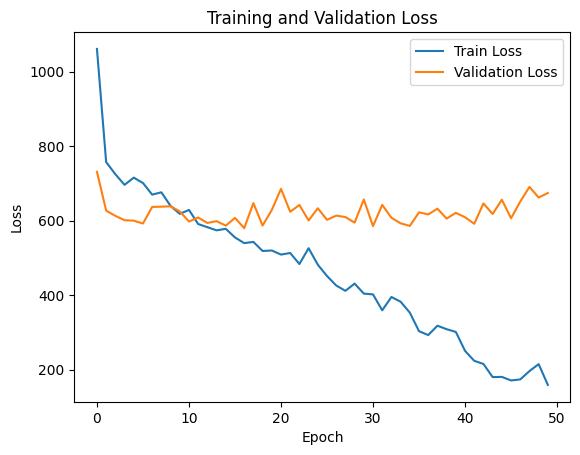

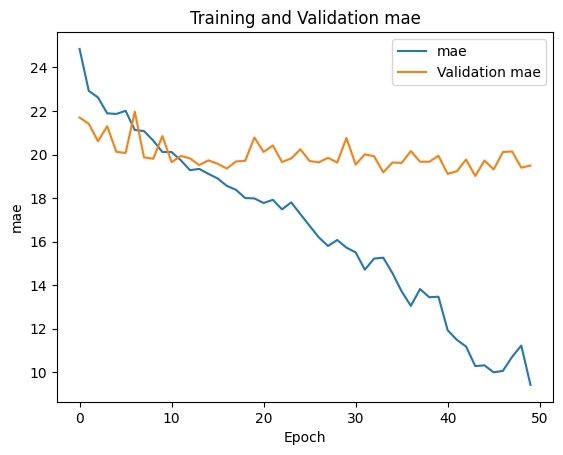

In [59]:
# 손실 그래프
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# MAE 그래프
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label='Validation mae')
plt.title('Training and Validation mae')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.legend()
plt.show()

## 예시 이미지를 통해서 학습 결과 확인

In [ ]:
# Evaluate the model on the test set
results = model_age.evaluate(X_test, y_test, batch_size=32)

# Print the evaluation results
print("Test Loss:", results[0])
print("Test MAE (Mean Absolute Error):", results[1])


6/6 [==============================] - 5s 718ms/step - loss: 705.0602 - mae: 20.0275
Test Loss: 705.0601806640625
Test MAE (Mean Absolute Error): 20.027469635009766


In [ ]:
# 예측을 얻기 위해 모델을 사용
sample_index = 0  # 테스트 셋에서 확인하고 싶은 이미지의 인덱스
sample_image = X_test[sample_index].reshape(1, 48, 48, 3)  # 배치 차원 추가

# 예측 수행
prediction = model_age.predict(sample_image)

# 예측 결과 출력
print("실제 나이:", y_test[sample_index])
print("모델 예측 나이:", prediction[0, 0])


1/1 [==============================] - 0s 192ms/step
실제 나이: 42
모델 예측 나이: 21.372742


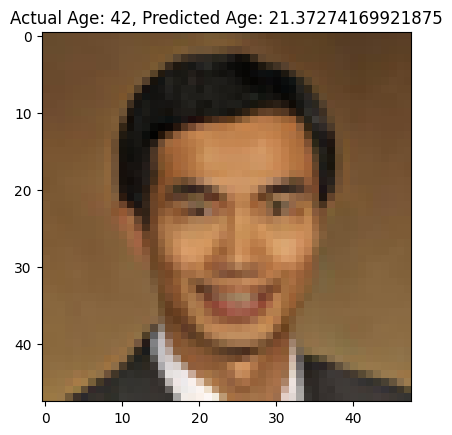

In [ ]:
plt.imshow(X_test[sample_index])
plt.title(f"Actual Age: {y_test[sample_index]}, Predicted Age: {prediction[0, 0]}")
plt.show()

## 모델 저장

In [ ]:
# 모델 저장

# 모델을 저장할 경로 및 파일명 정의
model_save_path = '/content/drive/MyDrive/model_age_prediction.h5'

# 모델 저장
model_age.save(model_save_path)


# 성별 판별 모델

## 실제 이미지 불러오기 및 모델 구성과 학습

In [56]:
import pandas as pd
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import numpy as np
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/dataset_info.csv')  # Replace 'your_dataset.csv' with the actual path to your dataset

# Assuming you have the images stored in '/content/drive/MyDrive/part1/'
image_folder_path = '/content/drive/MyDrive/part1/'

from PIL import Image

def load_and_preprocess_image(filename):
    try:
        img = Image.open(image_folder_path + filename)
        img = img.convert('RGB')  # 이미지를 RGB 모드로 변환
        img = img.resize((48, 48))  # 원하는 크기로 이미지 크기 조정
        img_array = np.array(img)
        img_array = img_array / 255.0  # 픽셀 값을 0에서 1 사이로 정규화
        return img_array
    except Exception as e:
        print(f"이미지 {filename} 로드 중 오류 발생: {str(e)}")
        return None

# 데이터프레임의 모든 파일 이름에 전처리 함수를 적용합니다.
df['image'] = df['filename'].apply(load_and_preprocess_image)

# None 항목을 필터링합니다.
df = df.dropna()

# 'image' 열을 numpy 배열로 변환합니다.
X = np.stack(df['image'].to_numpy())

# Apply the preprocessing function to all filenames in the dataframe
df['image'] = df['filename'].apply(load_and_preprocess_image)

# Convert the 'image' column to a numpy array
X = np.stack(df['image'].to_numpy())

# Extract the labels
y = df['gender'].to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
input_shape = (48, 48, 3)
input_layer = Input(shape=input_shape)

# ... (your model architecture)
cnn1 = Conv2D(36, kernel_size=3, activation='relu')(input)
cnn1 = MaxPool2D(pool_size=3, strides=2)(cnn1)
cnn2 = Conv2D(64, kernel_size=3, activation='relu')(cnn1)
cnn2 = MaxPool2D(pool_size=3, strides=2)(cnn2)
cnn3 = Conv2D(128, kernel_size=3, activation='relu')(cnn2)
cnn3 = MaxPool2D(pool_size=3, strides=2)(cnn3)

dense = Flatten()(cnn3)
dense = Dropout(0.2)(dense)
dense = Dense(512, activation='relu')(dense)
dense = Dense(512, activation='relu')(dense)
output = Dense(1, activation='sigmoid', name='gender')(dense)
model_sex = Model(input, output)
model_sex.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history = model_sex.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

이미지 18_1_3_20170109214031495.jpg 로드 중 오류 발생: image file is truncated (6 bytes not processed)
Epoch 1/100
23/23 [==============================] - 8s 212ms/step - loss: 0.6859 - accuracy: 0.5679 - val_loss: 0.6755 - val_accuracy: 0.6011
Epoch 2/100
23/23 [==============================] - 8s 349ms/step - loss: 0.6815 - accuracy: 0.5665 - val_loss: 0.6702 - val_accuracy: 0.6011
Epoch 3/100
23/23 [==============================] - 6s 263ms/step - loss: 0.6787 - accuracy: 0.5652 - val_loss: 0.6838 - val_accuracy: 0.5519
Epoch 4/100
23/23 [==============================] - 3s 133ms/step - loss: 0.6808 - accuracy: 0.5734 - val_loss: 0.6666 - val_accuracy: 0.6011
Epoch 5/100
23/23 [==============================] - 5s 202ms/step - loss: 0.6690 - accuracy: 0.5706 - val_loss: 0.6628 - val_accuracy: 0.6011
Epoch 6/100
23/23 [==============================] - 8s 337ms/step - loss: 0.6582 - accuracy: 0.5871 - val_loss: 0.6580 - val_accuracy: 0.6066
Epoch 7/100
23/23 [==============================

## 학습 과정 시각화

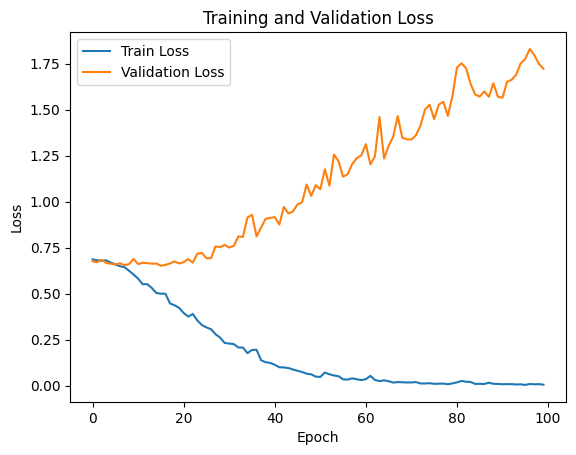

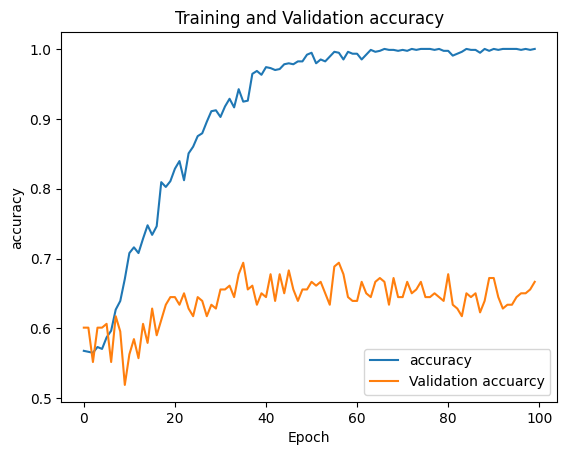

In [57]:
# 손실 그래프
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# MAE 그래프
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuarcy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## 예시 이미지를 통해서 학습 결과 확인

In [ ]:
# Evaluate the model on the test set
results = model_age.evaluate(X_test, y_test, batch_size=32)

# Print the evaluation results
print("Test Loss:", results[0])
print("Test MAE (Mean Absolute Error):", results[1])


6/6 [==============================] - 10s 2s/step - loss: 734.1879 - mae: 20.9262
Test Loss: 734.1879272460938
Test MAE (Mean Absolute Error): 20.926246643066406


In [ ]:
# 예측을 얻기 위해 모델을 사용
sample_index = 0  # 테스트 셋에서 확인하고 싶은 이미지의 인덱스
sample_image = X_test[sample_index].reshape(1, 48, 48, 3)  # 배치 차원 추가

# 예측 수행
prediction = model_sex.predict(sample_image)

# 예측 결과 출력
print("실제 성별:", y_test[sample_index])
print("모델 예측 성별:", prediction[0, 0])

1/1 [==============================] - 0s 99ms/step
실제 성별: 0
모델 예측 성별: 6.983527e-05


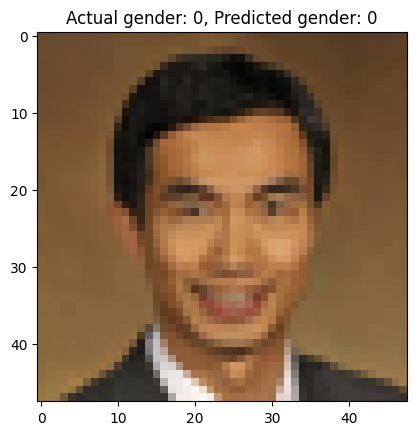

In [ ]:
# 예측값을 0과 1 이진값으로 나오게 변환
prediction = (prediction > 0.5).astype(int)

plt.imshow(X_test[sample_index])
plt.title(f"Actual gender: {y_test[sample_index]}, Predicted gender: {prediction[0, 0]}")
plt.show()

## 모델 저장

In [ ]:
# 모델을 저장할 경로 및 파일명 정의
model_save_path = '/content/drive/MyDrive/model_sex_prediction.h5'

# 모델 저장
model_sex.save(model_save_path)

